# Deep Learning with PyTorch : GradCAM (Gradient-weighted Class Activated Mapping)

*Author: Eda AYDIN*


# Business Understanding

Grad-CAM is a techniques used in computer vision to understand how a neural network model makes decisions. Grad-CAM stands for Gradient-weighted Class Activated Mapping, which helps to visualize which regions of an image are important for classification decision made by the neural network. 

This technique can be useful in a variety of applications, such as self-driving cars, medical diagnosis, and image recognition systems. By understanding the regions of an image that the model is focusing on, we can gain insights into how the model is making its decisions and potentially improve its performance. 

In addition, Grad-CAM can be used for model interpretability, explaining the reasoning behind a model's decisions, and helping to build trust and transparency with end-users. 

Overall, Grad-CAM is a valuable tool for anyone working in computer vision and looking to gain a deeper understanding of their models.

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations -q
!pip install -upgrade opencv-contrib-python -q

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 10.86 MiB/s, done.

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


# Imports

In [2]:
import sys
sys.path.append('/kaggle/working/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/kaggle/working/GradCAM-Dataset/train.csv'
DATA_DIR = '/kaggle/working/GradCAM-Dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16 
LR = 0.001
EPOCHS = 20

In [5]:
data = pd.read_csv(CSV_FILE)
data.head()

# Meaning of Label Values
# cucumber  = 0, eggplant = 1, mushroom = 2,


,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [8]:
trainset = utils.ImageDataset(train_df, augs = train_augs,
                             data_dir = DATA_DIR)

validset = utils.ImageDataset(valid_df, augs = valid_augs,
                            data_dir = DATA_DIR)

Text(0.5, 1.0, 'eggplant')

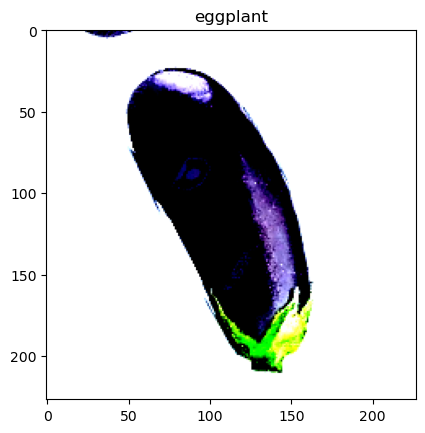

In [9]:
image, label = trainset[0] # (c, h, w) --> (h, w, c)

class_list = ["cucumber", "eggplant", "mushroom"]

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label])

In [10]:
print(f"No. of examples in the trainset: {len(trainset)}")
print(f"No. of examples in the validset: {len(validset)}")

No. of examples in the trainset: 148
No. of examples in the validset: 38


# Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [12]:
print("No. of batches in trainloader : {}".format(len(trainloader)))
print("No. of batches in validloader: {}".format(len(validloader)))

No. of batches in trainloader : 10
No. of batches in validloader: 3


In [13]:
for images, labels in trainloader:
    break

print("One batch image shape: {}".format(images.shape))
print("One batch label shape: {}".format(labels.shape))

One batch image shape: torch.Size([16, 3, 227, 227])
One batch label shape: torch.Size([16])


# Create Model

![]()

In [14]:
class ImageModel(nn.Module):
    
    def __init__(self):
        super(ImageModel, self).__init__()
    
        self.feature_extractor = nn.Sequential(
            # First layer
            nn.Conv2d(in_channels = 3,out_channels = 16,kernel_size = (5,5),padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),
            # Second Layer
            nn.Conv2d(in_channels = 16,out_channels = 16,kernel_size = (5,5),padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),
            # Third Layer
            nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = (5,5),padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),
            # Last Layer
            nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = (5,5),padding = 1),
            nn.ReLU(),
            
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )
        
        self.gradient = None
    
    def activations_hook(self, grad):
        self.gradient = grad
        
    def forward(self, images):
        
        x = self.feature_extractor(images) # activation maps
        
        h = x.register_hook(self.activations_hook)
        x = self.maxpool(x)
        x = self.classifier(x)
        
        return x
    
    def get_activation_gradients(self): # a1, a2, a3 .. ak
        return self.gradient
    
    def get_activations(self, x): # A1, A2, A3, ... AK
        return self.feature_extractor(x)

In [15]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval Function

In [16]:
def train_fn(dataloader, model, optimizer, criterion):
    
    model.train()
    total_loss = 0.0
    for images ,labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [17]:
def eval_fn(dataloader, model, criterion):
    
    model.eval()
    total_loss = 0.0
    for images ,labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        logits = model(images)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

# Training Loop

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer, criterion)
    valid_loss = eval_fn(validloader, model, criterion)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_weights.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")
    
    print("EPOCHS : {} TRAIN LOSS : {} VALID LOSS : {}".format(i+1, train_loss, valid_loss))

100%|██████████| 3/3 [00:00<00:00, 39.71it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 TRAIN LOSS : 1.2218804597854613 VALID LOSS : 1.0882409413655598


100%|██████████| 3/3 [00:00<00:00, 39.50it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 TRAIN LOSS : 1.0367589175701142 VALID LOSS : 1.0778769453366597


100%|██████████| 3/3 [00:00<00:00, 38.47it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 TRAIN LOSS : 0.8380049407482147 VALID LOSS : 0.7638177871704102


100%|██████████| 3/3 [00:00<00:00, 40.59it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 TRAIN LOSS : 0.7277225762605667 VALID LOSS : 0.515953799088796


100%|██████████| 3/3 [00:00<00:00, 35.14it/s]


EPOCHS : 5 TRAIN LOSS : 0.603229022026062 VALID LOSS : 0.5849324266115824


100%|██████████| 3/3 [00:00<00:00, 30.65it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 6 TRAIN LOSS : 0.5185425534844399 VALID LOSS : 0.43507277965545654


100%|██████████| 3/3 [00:00<00:00, 37.85it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 TRAIN LOSS : 0.4847055822610855 VALID LOSS : 0.364939088622729


100%|██████████| 3/3 [00:00<00:00, 36.70it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 8 TRAIN LOSS : 0.39875304996967315 VALID LOSS : 0.35014481842517853


100%|██████████| 3/3 [00:00<00:00, 38.76it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 9 TRAIN LOSS : 0.284372790902853 VALID LOSS : 0.18601766414940357


100%|██████████| 3/3 [00:00<00:00, 40.82it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 10 TRAIN LOSS : 0.18065855111926793 VALID LOSS : 0.13390828606983027


100%|██████████| 3/3 [00:00<00:00, 40.28it/s]


EPOCHS : 11 TRAIN LOSS : 0.18955761045217515 VALID LOSS : 0.3522847176839908


100%|██████████| 3/3 [00:00<00:00, 39.76it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 12 TRAIN LOSS : 0.18676182627677917 VALID LOSS : 0.10027235994736354


100%|██████████| 3/3 [00:00<00:00, 33.30it/s]


EPOCHS : 13 TRAIN LOSS : 0.1102609658613801 VALID LOSS : 0.708158959945043


100%|██████████| 3/3 [00:00<00:00, 39.84it/s]


EPOCHS : 14 TRAIN LOSS : 0.10258841267495881 VALID LOSS : 0.3302794365833203


100%|██████████| 3/3 [00:00<00:00, 40.21it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 15 TRAIN LOSS : 0.16112756449729204 VALID LOSS : 0.09039032645523548


100%|██████████| 3/3 [00:00<00:00, 34.29it/s]


EPOCHS : 16 TRAIN LOSS : 0.0832505937665701 VALID LOSS : 0.15702642500400543


100%|██████████| 3/3 [00:00<00:00, 35.50it/s]


EPOCHS : 17 TRAIN LOSS : 0.04325619358569384 VALID LOSS : 0.19801628874847665


100%|██████████| 3/3 [00:00<00:00, 39.71it/s]


EPOCHS : 18 TRAIN LOSS : 0.23661383632570504 VALID LOSS : 0.17600010335445404


100%|██████████| 3/3 [00:00<00:00, 41.12it/s]


EPOCHS : 19 TRAIN LOSS : 0.15542010478675367 VALID LOSS : 0.13617669542630514


100%|██████████| 3/3 [00:00<00:00, 40.10it/s]

EPOCHS : 20 TRAIN LOSS : 0.07410518897231669 VALID LOSS : 0.18396957591176033


# Get GradCAM

In [20]:
def get_gradcam(model, image, label, size):
    label.backward()
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) # a1, a2, ...ak
    activations = model.get_activations(image).detach() #A1, A2, ... Ak
    
    for i in range(activations.shape[1]):
        activations[:,i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))
    
    return heatmap

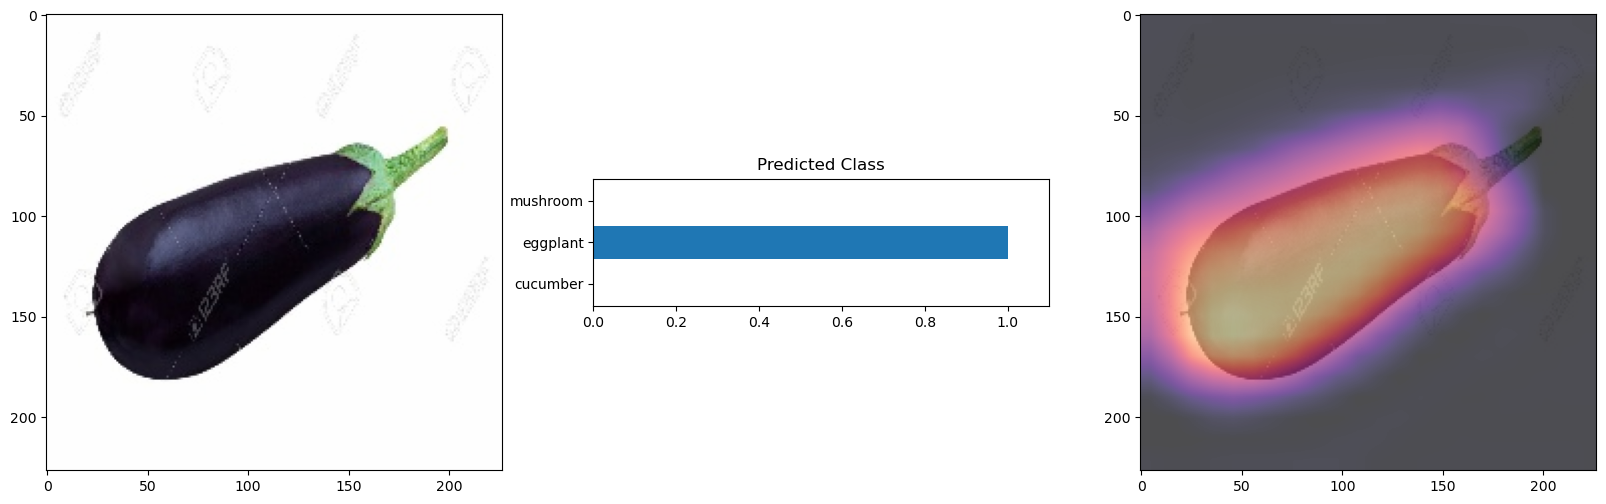

In [21]:
image, label = validset[4]

denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)